In [1]:
import numpy as np
import pandas as pd
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
import pydot
from IPython.display import SVG
from sklearn.model_selection import train_test_split
import keras.backend as K
K.set_image_data_format('channels_last')
import math
import keras

from matplotlib import pyplot as plt
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
from keras import regularizers
# initiate notebook for offline plot
init_notebook_mode(connected=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib.ticker import PercentFormatter, FormatStrFormatter, ScalarFormatter
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from random import randrange
from scipy.stats import norm
import re
import numpy as np
import seaborn as sns

The models in this script are implemented using the "functional" API of Keras (as opposed to its "sequencial" API, [their differences](https://stackoverflow.com/a/58092554/947889)). 

Interesting blog posts:
- https://keras.io/examples/generative/vae/
- https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
- http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
- https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/
- https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
- https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
- https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df

Overview: 

1. Load data; 
2. Split into dev, train, and eval sets;
3. normalize sets separately;

# Load, Normalize, and Split Data

Should data be normalized before or after they're split (see [this](https://datascience.stackexchange.com/a/27616/106388) and [this](https://stats.stackexchange.com/a/375183/269404)). We had a chat and agreed on normalizing data after the split.

In [2]:
def get_data():
    # Load Data
    # We load data into RAM since data is small and will fit in memory.
    cells = pd.read_csv("tumor_cycif.csv")
    
    # Keeps only the 'interesting' columns.
    cells = cells.filter(regex="Cell Masks$", axis=1).filter(regex="^(?!(Goat|DAPI))", axis=1)
    markers = cells.columns
    markers = [re.sub("\_Cell Masks", "", x) for x in markers]
    cells = np.array(cells)
    
    return cells, markers

def normalize(data):
    # Normalize Data
    
    # Input data contains some zeros which results in NaN (or Inf)
    # values when their log10 is computed. NaN (or Inf) are problematic
    # values for downstream analysis. Therefore, zeros are replaced by 
    # a small value; see the following thread for related discussion.
    # https://www.researchgate.net/post/Log_transformation_of_values_that_include_0_zero_for_statistical_analyses2
    data[data==0] = 1e-32
    data = np.log10(data)
    
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # Remove outlier using interquartile range
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1
    # Filtering Values between q1- 1.5 * iqr and q3 + 1.5 iqr
    data = data[~((data < (q1 - 1.5 * iqr)) |(data > (q3 + 1.5 * iqr))).any(axis=1)]

    # A simple max normalization, may worth trying 
    # alternative normalization methods 
    # (e.g., 0-1 normalization)
    # data = data / data.max(axis=0)
    return data

inputs, markers = get_data()
# Number of cells
assert inputs.shape[0] == 12142
# Number of features per input
assert inputs.shape[1] == 25

# random_state is a random seed to have a reproducible shuffling (only for dev purpose).
X_dev,   X_val  = train_test_split(inputs, test_size=0.05, random_state=1, shuffle=True)
X_train, X_test = train_test_split(X_dev,  test_size=0.25, random_state=1)

# This is primarily for the purpose of 
# being able to see how much data is removed
# (as part of outlier removal) and plot
# the changes in data distribution.
init_inputs = inputs
init_X_train = X_train
init_X_test = X_test
init_X_val = X_val

inputs = normalize(inputs)
X_train = normalize(X_train)
X_test = normalize(X_test)
X_val = normalize(X_val)

## Get an Overview of the Data

In [3]:
def get_percentage(new_num, org_num):
    return round((new_num * 100) / org_num, 2)


print(f"                        Input Shape:\t{init_inputs.shape}")
print(f"                                    \t{init_inputs.shape[0]} cells")
print(f"                                    \t{init_inputs.shape[1]} markers\n")
print(f"    Input size before normalization:\t{init_inputs.shape}")
print(f"Input data size after normalization:\t{inputs.shape}")
print(f"            Removed data percentage:\t{100 - get_percentage(inputs.shape[0], init_inputs.shape[0])}%")
print("")
print(f"         Normalized Train data size:\t{X_train.shape}\tOriginal size: {init_X_train.shape}\t({get_percentage(init_X_train.shape[0], init_inputs.shape[0])}% of input)")
print(f"          Normalized Test data size:\t{X_test.shape}\tOriginal size: {init_X_test.shape}\t({get_percentage(init_X_test.shape[0], init_inputs.shape[0])}% of input)")
print(f"    Normalized Validation data size:\t{X_val.shape}\tOriginal size: {init_X_val.shape}\t({get_percentage(init_X_val.shape[0], init_inputs.shape[0])}% of input)")

# NOTE: the number of cells in X_train, X_test, and X_val would NOT
# add up to the number of cells in inputs if outliers are removed. 
# It is because outliers are removed after the cells in inputs 
# is split between train, test, and val sets.

                        Input Shape:	(12142, 25)
                                    	12142 cells
                                    	25 markers

    Input size before normalization:	(12142, 25)
Input data size after normalization:	(9531, 25)
            Removed data percentage:	21.5%

         Normalized Train data size:	(7122, 25)	Original size: (8650, 25)	(71.24% of input)
          Normalized Test data size:	(2013, 25)	Original size: (2884, 25)	(23.75% of input)
    Normalized Validation data size:	(506, 25)	Original size: (608, 25)	(5.01% of input)


## Some Checkes on the Normalized Data

In [4]:
rnd = randrange(0, inputs.shape[1])
# Mean should be zero and standard deviation 
# should be 1. However, due to some challenges 
# relationg to floating point positions and rounding, 
# the values should be very close to these numbers.
# For details, see:
# https://stackoverflow.com/a/40405912/947889
# Hence, we assert the rounded values.
print(inputs[:,rnd].std())
print(inputs[:,rnd].mean())

0.8803612802754204
-0.05429108002570968


## Plot Normalized Data Distributions

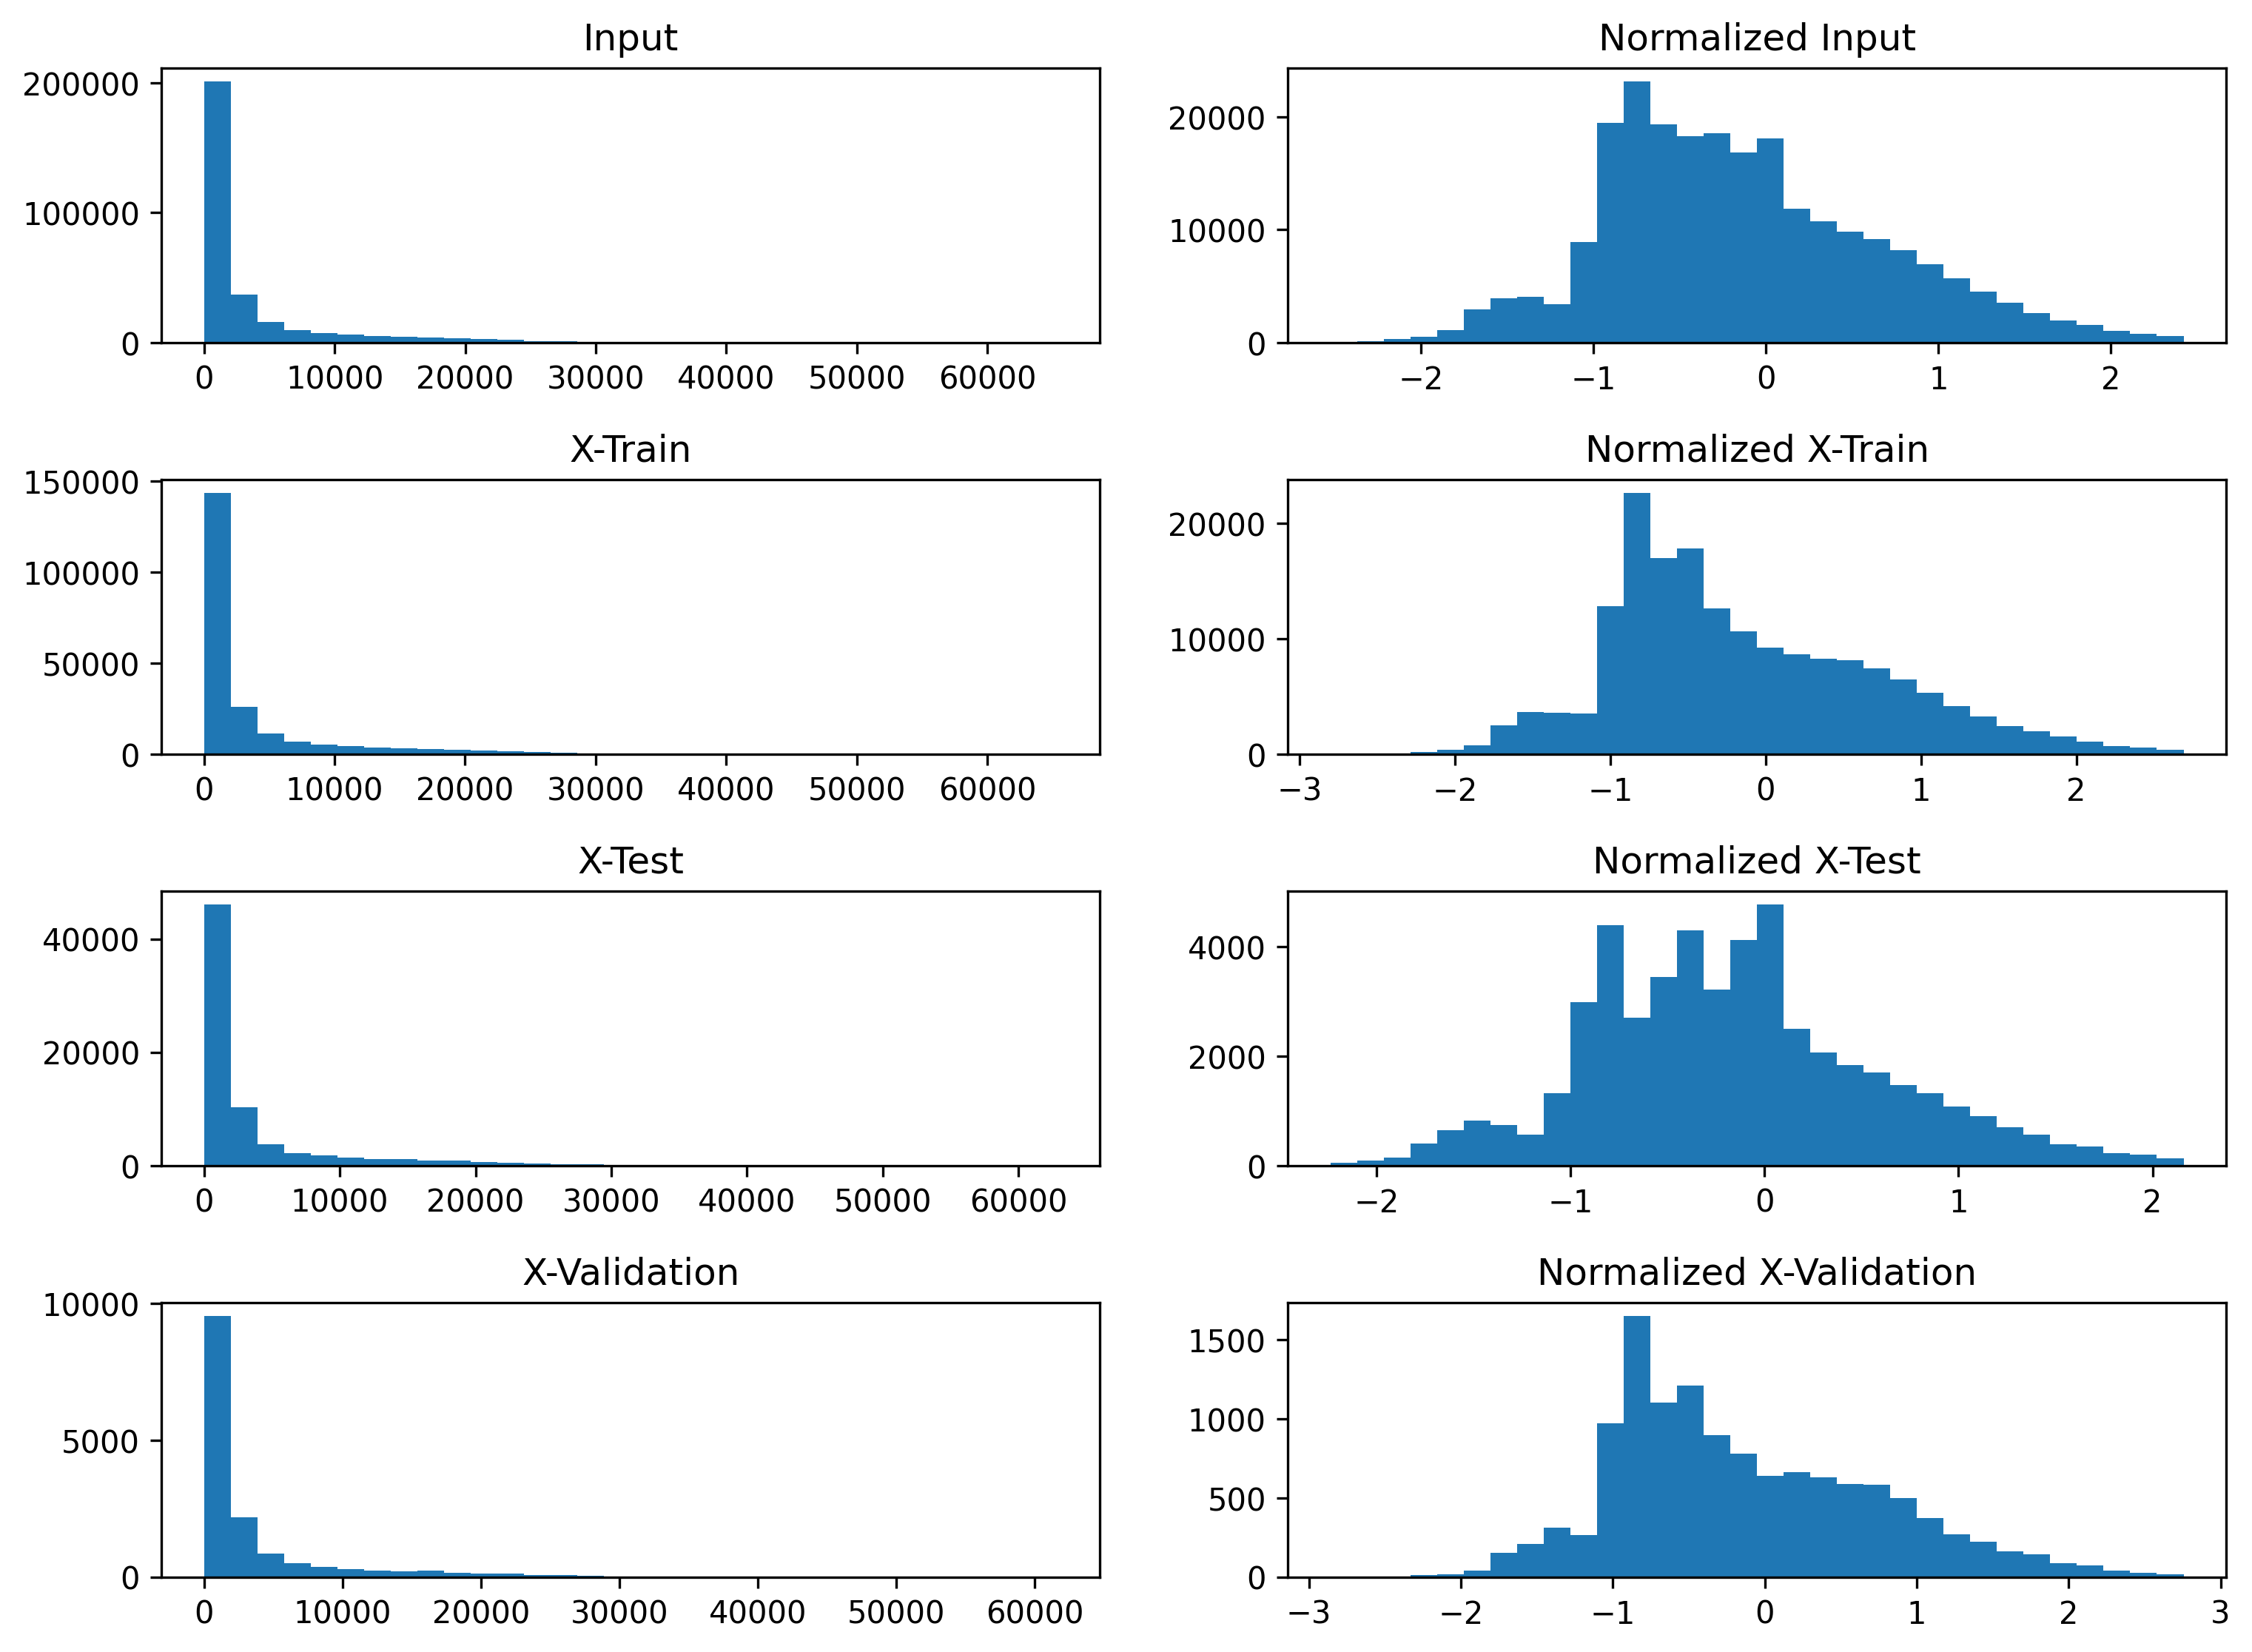

In [5]:
def plot_dists(ax, data, title, plot_type=""):
    # Flatten data, `ravel` yields a 1D "view",
    # which is more efficient than creating a 1D copy.
    f_data = data.ravel()
    
    if plot_type == "density":
        density = stats.gaussian_kde(f_data)
        n, x, _ = plt.hist(f_data, bins=25, histtype="step", density=True)
        ax.plot(x, density(x))
    elif plot_type == "both":
        density = stats.gaussian_kde(f_data)
        n, x, _ = ax.hist(f_data, bins=25, histtype="bar", density=True)
        ax.plot(x, density(x))
    else:
        ax.hist(f_data, bins=32, histtype="bar")
    ax.set_title(title)
    #ax.set_yscale('log')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 9), dpi=300)
plt.subplots_adjust(wspace=0.20, hspace=0.50)
plot_dists(axs[0, 0], init_inputs, "Input")
plot_dists(axs[0, 1], inputs, "Normalized Input")
plot_dists(axs[1, 0], init_X_train, "X-Train")
plot_dists(axs[1, 1], X_train, "Normalized X-Train")
plot_dists(axs[2, 0], init_X_test, "X-Test")
plot_dists(axs[2, 1], X_test, "Normalized X-Test")
plot_dists(axs[3, 0], init_X_val, "X-Validation")
plot_dists(axs[3, 1], X_val, "Normalized X-Validation")
plt.show()

# Define the Autoencoder

## Create a Sampling Layer

In [6]:
def sampling(mu_log_variance):
    z_mean, z_log_var = mu_log_variance
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the Encoder

In [7]:
# length of latent vector.
latent_dim = 6

inputs_dim = inputs.shape[1]

r = regularizers.l1(10e-5)

encoder_inputs = keras.Input(shape=(inputs_dim))
h1 = layers.Dense(inputs_dim, activation="relu", activity_regularizer=r)(encoder_inputs)
h2 = layers.Dense(inputs_dim / 2, activation="relu", activity_regularizer=r)(h1)
h3 = layers.Dense(inputs_dim / 3, activation="relu", activity_regularizer=r)(h2)

# last layer before flatten
lbf = h3

# The following is for the convenience of building the decoder.
# shape before flatten. 
sbf = keras.backend.int_shape(lbf)[1:]
# neurons count before latent dim
nbl = np.prod(sbf)

# VAE with normal distribution.
# This distribution will be randomly sampled to 
# return the output of the encoder.
z_mean = layers.Dense(latent_dim, name="z_mean")(lbf)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(lbf)

# Randomly sample the distribution. 
encoder_output = keras.layers.Lambda(sampling, name="encoder_output")([z_mean, z_log_var])

encoder = keras.models.Model(encoder_inputs, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 25)           650         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           312         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 8)            104         dense_1[0][0]                    
______________________________________________________________________________________

## Build the Decoder

In [8]:
decoder_inputs = keras.Input(shape=(latent_dim))
h1 = layers.Dense(nbl, activation="relu")(decoder_inputs)
h2 = layers.Dense(inputs_dim / 2, activation="relu")(h1)

# last decoder layer
ldl = h2
decoder_outputs = layers.Dense(inputs_dim, activation="sigmoid")(ldl)
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

# Visualize the model.
# tf.keras.utils.plot_model(model, to_file="model.png")

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_5 (Dense)              (None, 25)                325       
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________


## Custom Loss Function: KL Divergence

We implement [Kullback–Leibler (KL) divergence, also called relative entropy](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence)
loss function, which "is a measure of how one probability distribution is different from a second, reference probability distribution."

**Note:** This KL loss implementation is based on the code given [in this blog post](https://blog.paperspace.com/how-to-build-variational-autoencoder-keras/) and [this blog post](http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/).

In [9]:
def loss_func(encoder_mu, encoder_log_variance):

    def vae_loss(encoder_mu, encoder_log_variance):
        reconstruction_loss_factor = 1000
        reconstruction_loss = reconstruction_loss_factor * keras.backend.mean(keras.backend.square(encoder_mu - encoder_log_variance)) #, axis=[1, 2, 3])
        
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)

        return reconstruction_loss + kl_loss

    # A Note on the Syntax:
    # This is function closure (https://en.wikipedia.org/wiki/Closure_(computer_programming)),
    # a required syntax for custom Keras loss functions.
    return vae_loss

## Train the VAE

In [10]:
# Shape equals the encoder's input shape.
vae_input = keras.layers.Input(shape=(inputs_dim), name="VAE_input")
# Connect VAE's input to the encoder's input to get the encoded input:
vae_encoder_output = encoder(vae_input)
# Feed the encoded input to the decoder:
vae_decoder_output = decoder(vae_encoder_output)
# The VAE model connecting encoder and decoder:
vae = keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.compile(optimizer=keras.optimizers.Adam(lr=0.0005), loss=loss_func(z_mean, z_log_var), metrics=['mae', 'accuracy'])


# Visualize the model.
#tf.keras.utils.plot_model(vae, to_file="model.png")

history = vae.fit(X_train, X_train, epochs=100, batch_size=4, shuffle=True, validation_data=(X_test, X_test), verbose=0)

## Evaluate the model

In [11]:
print(f"Summary keys:\t{history.history.keys()}")
print(f"\nTrained Model Evaluation:\n{vae.evaluate(X_val, return_dict=True)}")

Summary keys:	dict_keys(['loss', 'mae', 'accuracy', 'val_loss', 'val_mae', 'val_accuracy'])
16/16 [==============================] - 0s 975us/step - loss: 0.0090 - mae: 0.0000e+00 - accuracy: 0.0000e+00

Trained Model Evaluation:
{'loss': 0.008986057713627815, 'mae': 0.0, 'accuracy': 0.0}


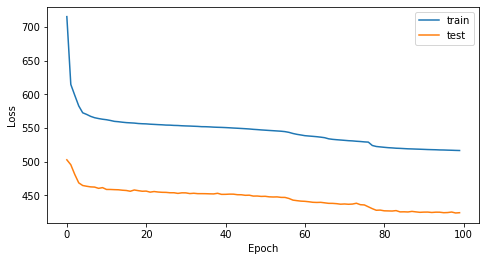

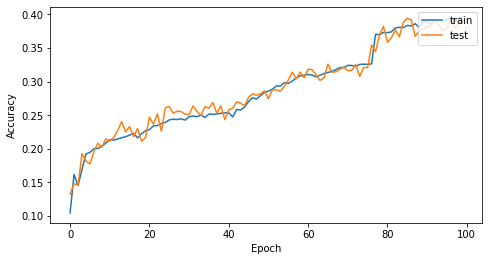

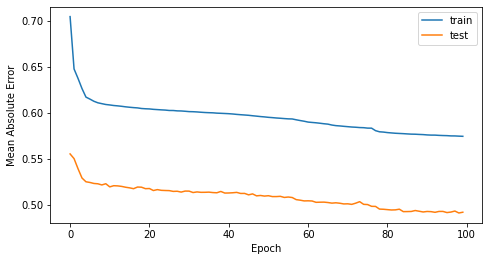

In [12]:
def plot(train, test, x_label):
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(train, label='train')
    ax.plot(test,  label='test')
    plt.xlabel('Epoch')
    plt.ylabel(x_label)
    plt.legend(loc='upper right')
    plt.show()

# Plot loss
plot(history.history['loss'], history.history['val_loss'], "Loss")
plot(history.history['accuracy'], history.history['val_accuracy'], "Accuracy")
plot(history.history['mae'], history.history['val_mae'], "Mean Absolute Error")

## Make Some Predictions
Note that for the prediction we're using the `X_val` set that was not visibile to training, hence the model could not try to fit according to its data.

In [13]:
cell = X_val[0]
# cell = cell.reshape(1, cell.shape[0], 1)
cell = cell.reshape(1, cell.shape[0])
encoded_cell = encoder.predict(cell)
decoded_cell = decoder.predict(encoded_cell)
var_cell = vae.predict(cell)
print(f"input shape:\t{cell.shape}")
print(f"encoded shape:\t{encoded_cell.shape}")
print(f"decoded shape:\t{decoded_cell.shape}")
print(f"\nInput:\n{cell}")
print(f"\nEncoded:\n{encoded_cell}")
print(f"\nDecoded:\n{decoded_cell}")

input shape:	(1, 25)
encoded shape:	(1, 6)
decoded shape:	(1, 25)

Input:
[[ 0.85602392  0.48712288  0.5616914   0.62077487  0.05005516 -0.01070649
   0.08892545  0.79526734  0.20649443  1.75138881  0.80066767  1.47630285
   1.15730284 -0.36794455  1.21370439  1.65386878  1.31037277  1.53017734
  -0.70232225 -0.48960011 -0.53594942 -0.67452858 -0.49128401 -0.84990061
  -0.9961513 ]]

Encoded:
[[ 3.1689794 15.702723   6.0051174  1.8630055 18.093729  -4.4412656]]

Decoded:
[[2.5438339e-02 4.3094456e-03 3.1175551e-01 5.2326143e-01 5.7219380e-01
  3.4148580e-01 4.8203886e-02 6.9871104e-01 6.3405991e-02 9.8749000e-01
  9.5514035e-01 9.9533808e-01 9.9999166e-01 5.5628717e-03 9.9504948e-01
  9.9439979e-01 9.9999976e-01 9.9718690e-01 3.5442927e-08 2.1765660e-05
  2.1951299e-08 7.5250810e-08 6.7875391e-08 4.3284075e-07 1.3118838e-06]]


# Exploring the Latent Space

In [18]:
# Get all the possible permutations. For instance: 
# Input with three possible values for two latent 
# variables: 
# [[0.01 0.5  0.99], [0.01 0.5  0.99]]
# 
# All the possible combinations:
# [[[0.01 0.01], [0.5  0.01], [0.99 0.01]],
#  [[0.01 0.5 ], [0.5  0.5 ], [0.99 0.5 ]],
#  [[0.01 0.99], [0.5  0.99], [0.99 0.99]]]

# Linearly spaced latent variables.
# Values are transformed through the inverse CDF (PPF)
# of the Gaussian since the prior of the latent space
# is Gaussian.
step_size = 4
z = np.array([np.linspace(-20, 30, step_size)] * latent_dim)
#z = norm.ppf(z)

z_grid = np.dstack(np.meshgrid(*z))
z_grid = z_grid.reshape(step_size ** latent_dim, latent_dim)

x_pred_grid = decoder.predict(z_grid)
x_pred_grid = np.block(list(map(list, x_pred_grid)))

## Distribution of Latent Variables

Text(0, 0.5, 'Values')

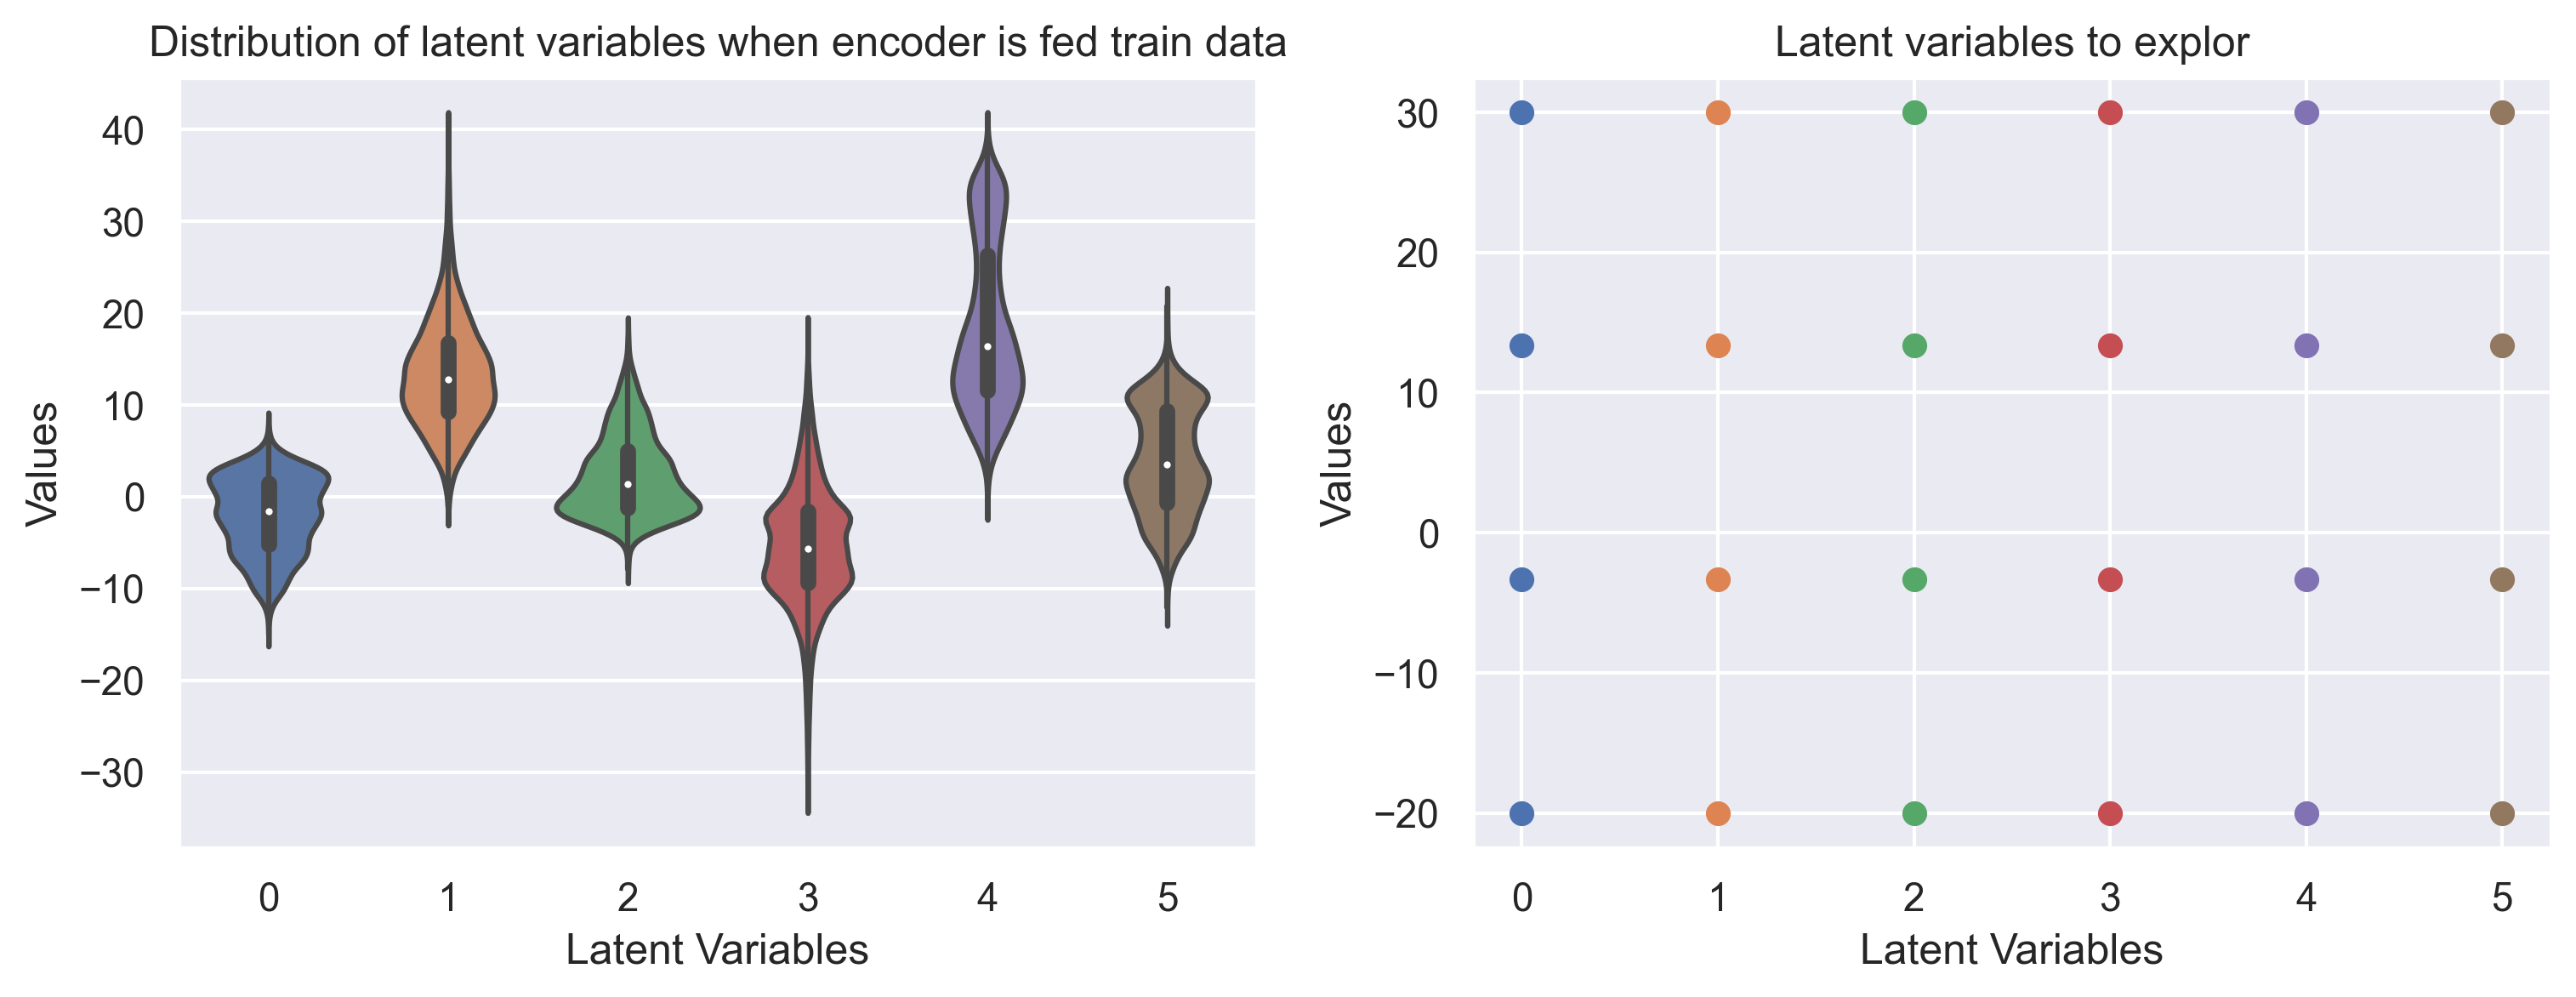

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4), dpi=300)
plt.subplots_adjust(wspace=0.2, hspace=0.1)

latent_values = encoder.predict(X_train)
sns.violinplot(data=latent_values, ax=ax1)

## Two visualization options: 
## Option 1: show the distribution of z_grid 
## (a matrix of shape (4096, 6) depending on the variables set):
#sns.violinplot(data=z_grid, ax=ax2)
#
## Option 2: show the latent variables as in z (not the meshgrid, 
## which is matrix of shape (6, 4) depending on the variables set):
for i in range(latent_dim):
    x = [i] * step_size
    y = z[i, :]
    ax2.scatter(x, y)
ax1.set_title("Distribution of latent variables when encoder is fed train data")
ax1.set_xlabel("Latent Variables")
ax1.set_ylabel("Values")

ax2.set_title("Latent variables to explor")
ax2.set_xlabel("Latent Variables")
ax2.set_ylabel("Values")

Text(0.5, 237.25000000000003, 'Marker')

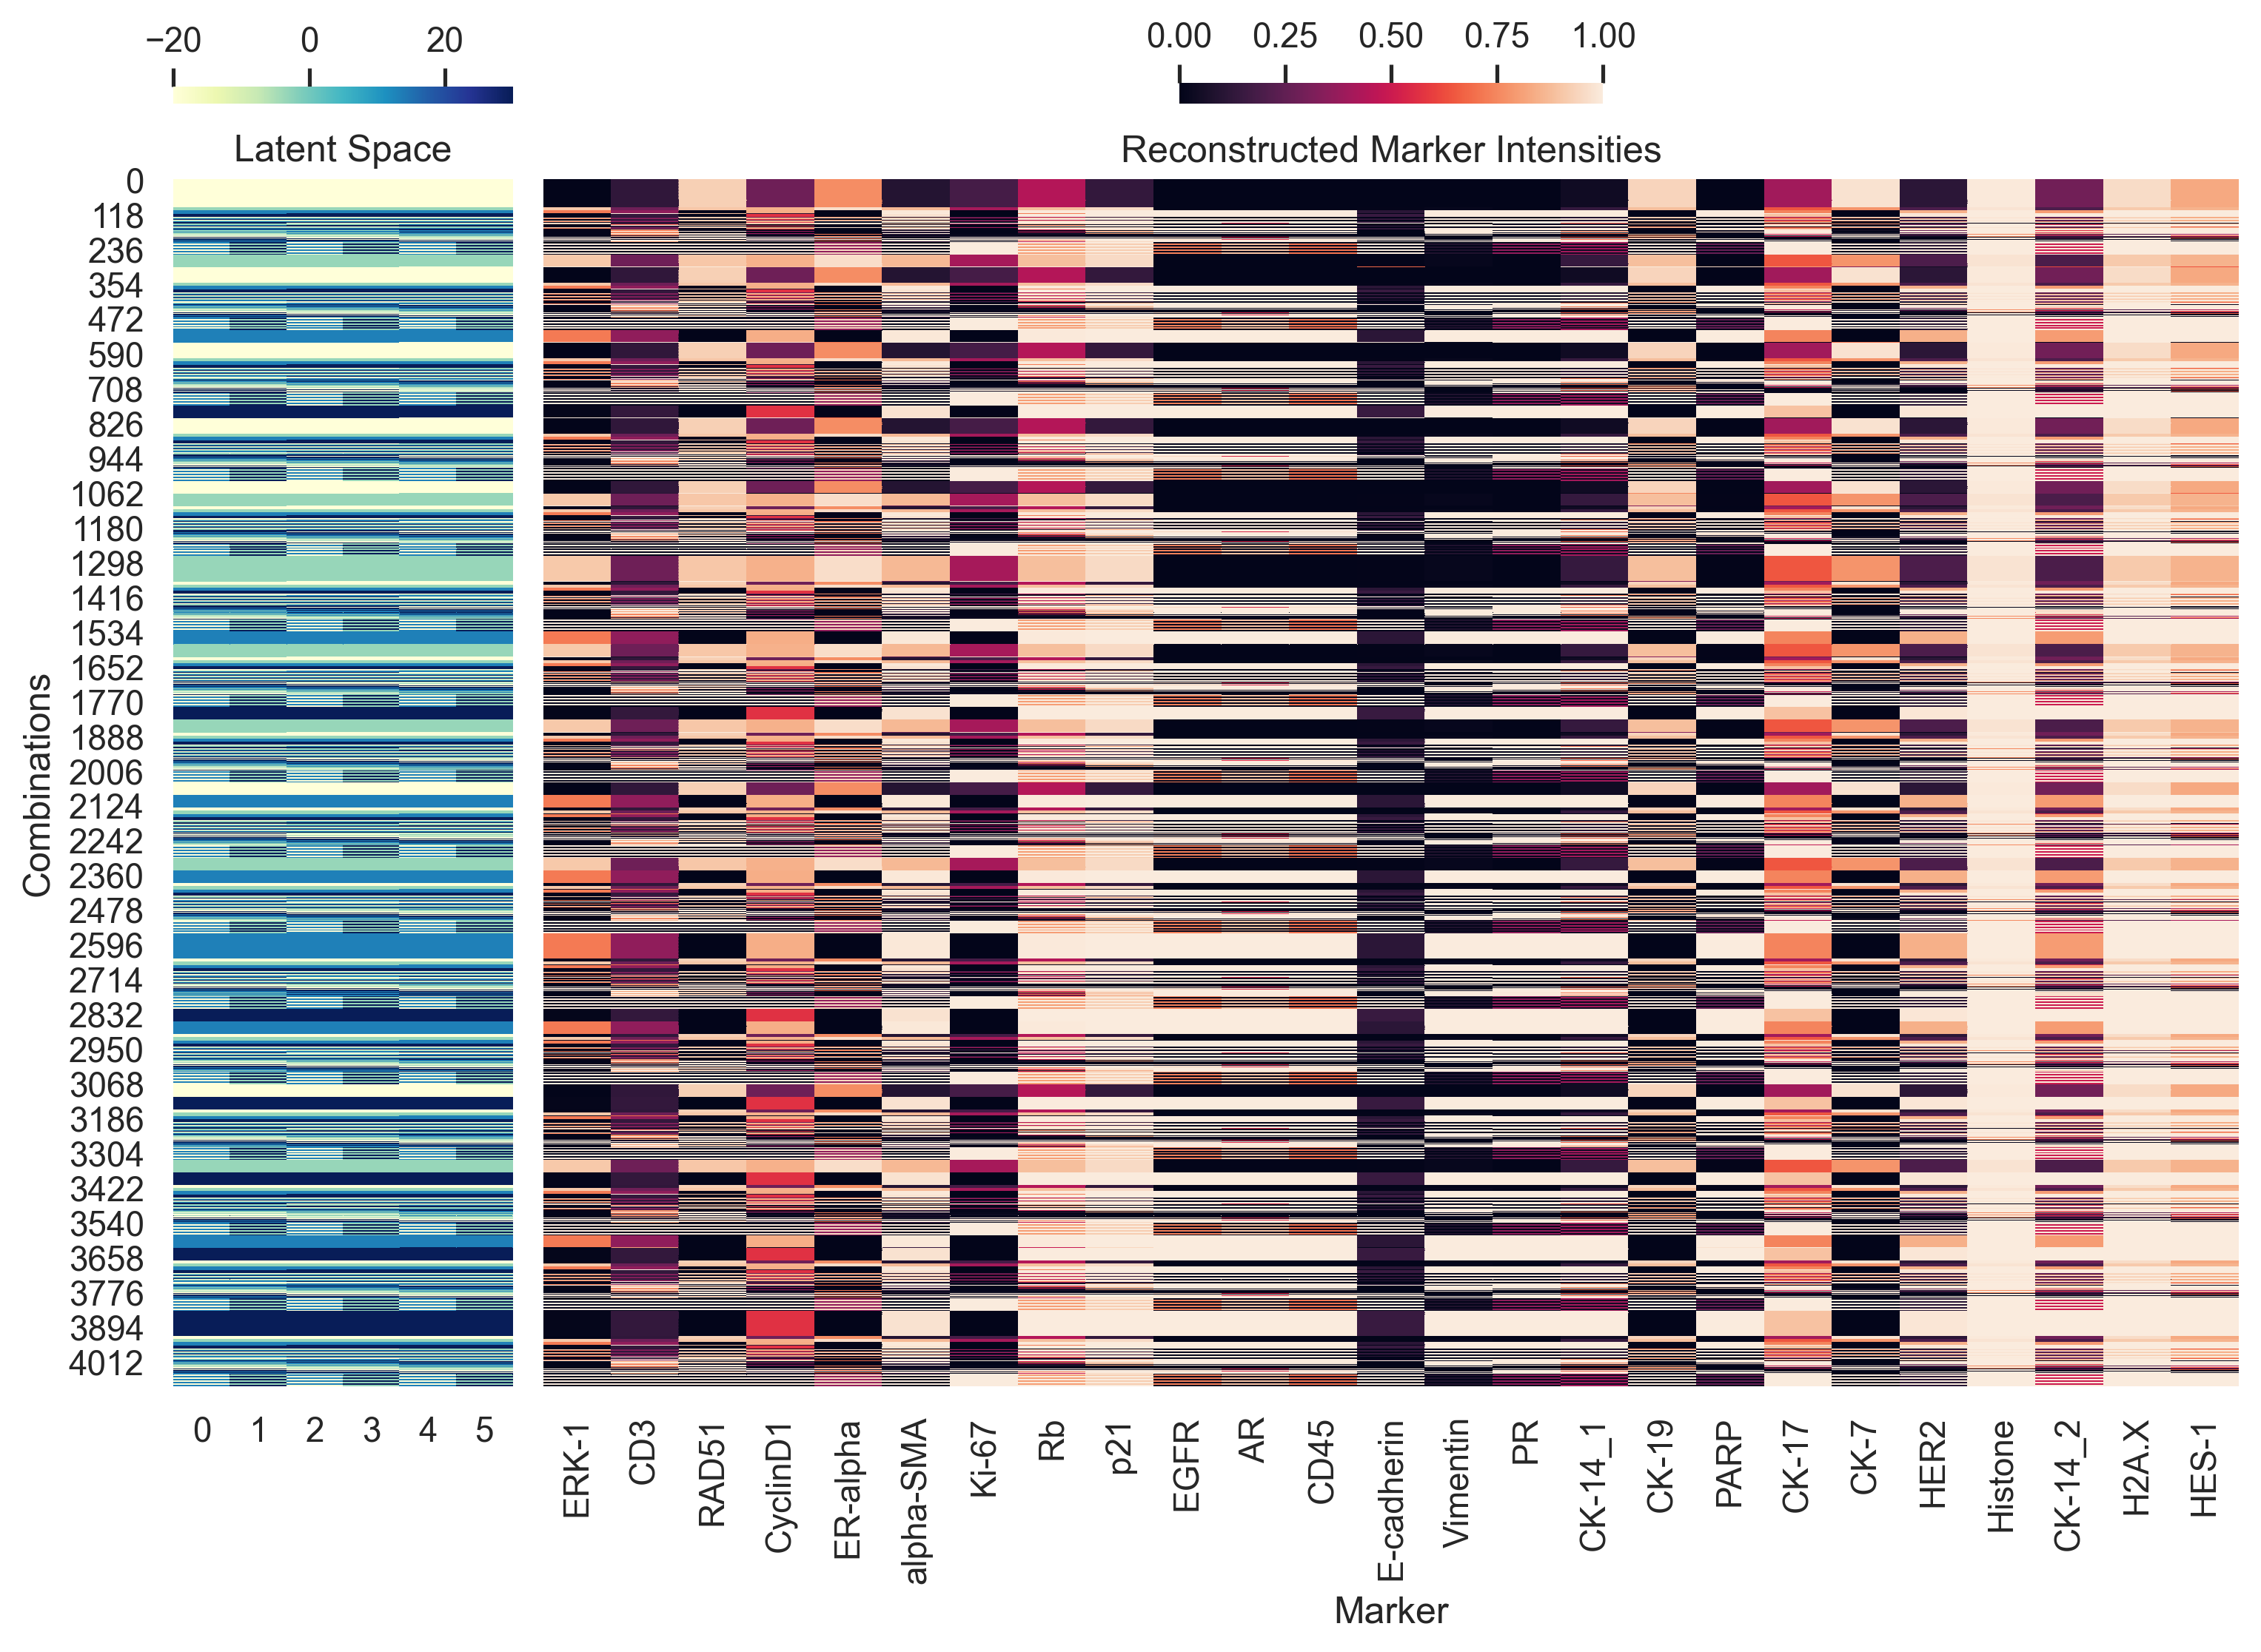

In [21]:
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 9), dpi=300, gridspec_kw={'width_ratios': [1, 5]})
plt.subplots_adjust(wspace=0.03, hspace=0.1)

sns.heatmap(z_grid, ax=ax1, cmap="YlGnBu", cbar_kws=dict(use_gridspec=False,location="top"))
sns.heatmap(x_pred_grid, ax=ax2, xticklabels=markers, yticklabels=False, cbar_kws=dict(use_gridspec=False,location="top", shrink=.25))

ax1.set_title("Latent Space")
ax1.set_ylabel("Combinations")

ax2.set_title("Reconstructed Marker Intensities")
ax2.set_xlabel("Marker")

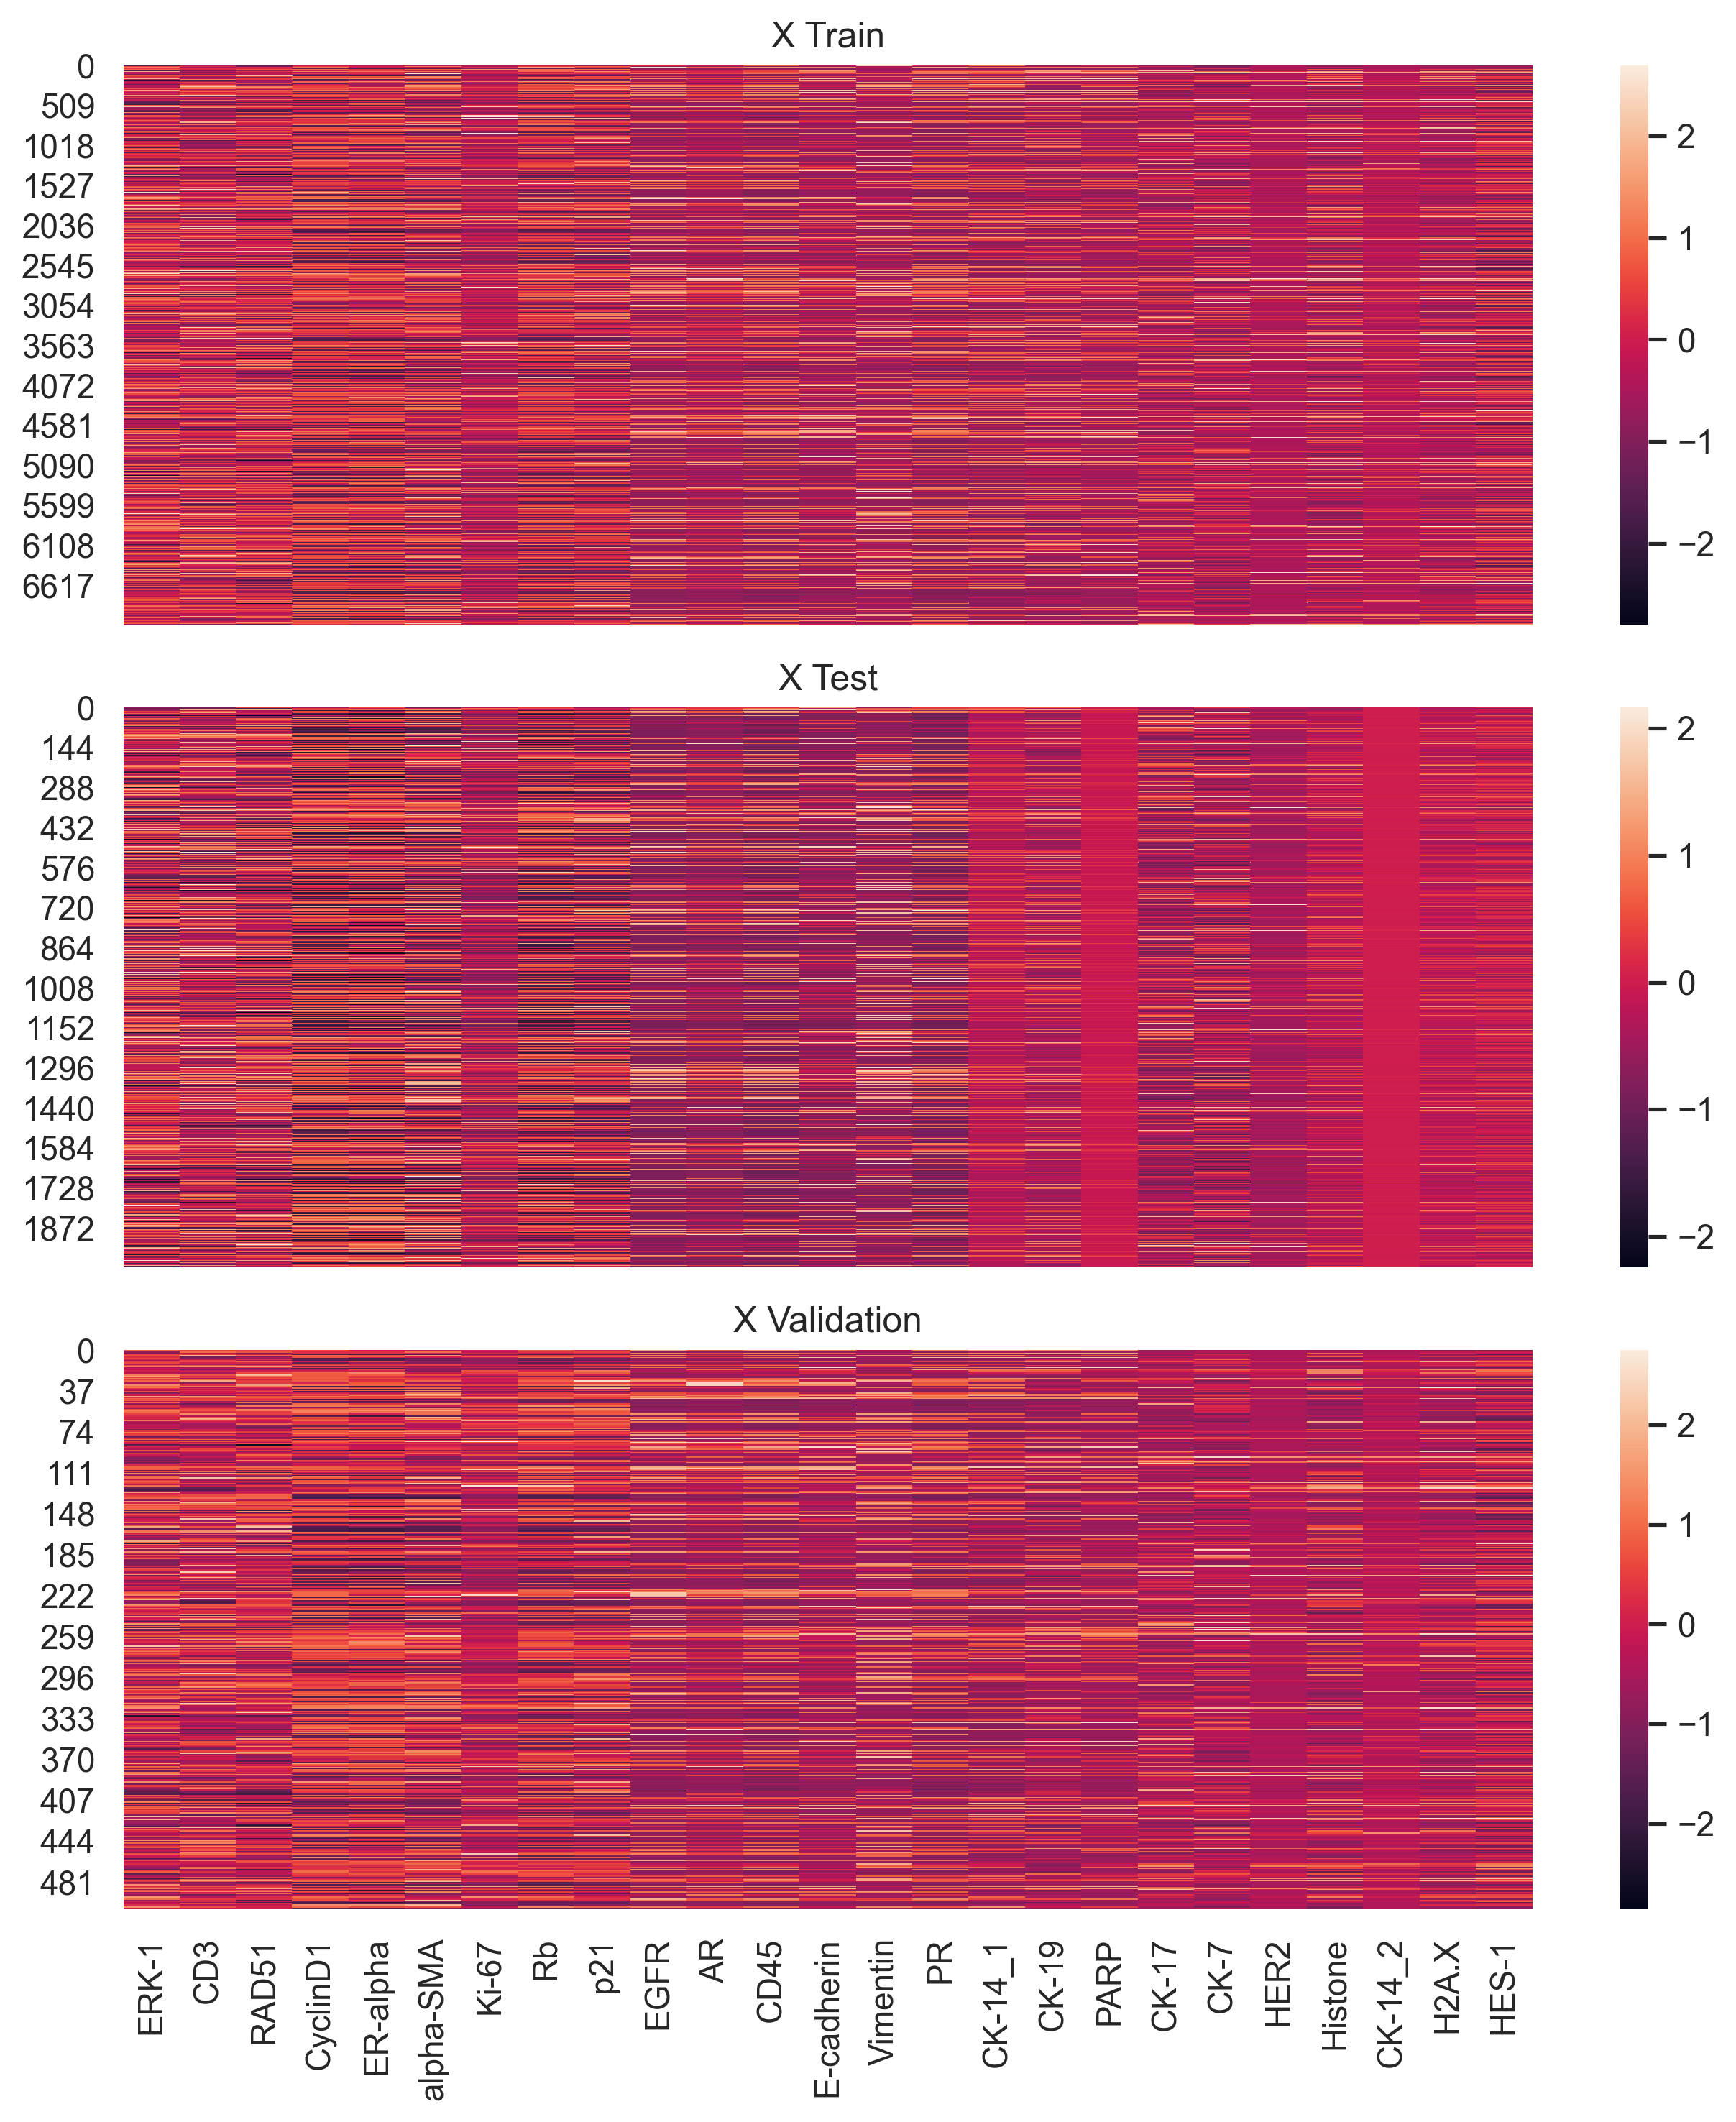

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 10), dpi=300, sharex=True)
sns.heatmap(X_train, ax=ax1, xticklabels=markers)
sns.heatmap(X_test,  ax=ax2, xticklabels=markers)
sns.heatmap(X_val,   ax=ax3, xticklabels=markers)

ax1.set_title("X Train")
ax2.set_title("X Test")
ax3.set_title("X Validation")
fig.tight_layout()